<a href="https://colab.research.google.com/gist/evenchange4/890f069575ef39225d57646db72c3d76/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats and Dogs

## Download dataset

https://stackoverflow.com/a/50650918/1932742

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy the data set locally.
!rm -rf /content/dataset
!kaggle competitions download --path '/content/dataset' -c dogs-vs-cats

# unzip
!unzip -q '/content/dataset/train.zip' -d '/content/dataset'
!unzip -q '/content/dataset/test1.zip' -d '/content/dataset'

# install tfjs
# !pip install -q tensorflowjs

-rw-r--r-- 1 root root 67 Sep  6 05:28 kaggle.json
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 69.8MB/s]
 96% 259M/271M [00:01<00:00, 151MB/s]
100% 271M/271M [00:01<00:00, 152MB/s]
 98% 535M/543M [00:04<00:00, 107MB/s] 
100% 543M/543M [00:04<00:00, 117MB/s]


## Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Define Constants

In [0]:
DATASET_PATH = "/content/dataset/"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test1/"
OUTPUT_PATH = "/content/drive/My Drive/colab/dogs-vs-cats/output/"
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
INPUT_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
batch_size=50
epochs=10


## Import Library

In [0]:
import numpy as np
import pandas as pd 
# import tensorflowjs as tfjs
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
import random
import os
# https://github.com/tensorflow/tensorflow/issues/18165#issuecomment-480056645
# tf.compat.v1.disable_eager_execution()

print(os.listdir(DATASET_PATH))

Using TensorFlow backend.


['train', 'sampleSubmission.csv', 'test1', 'train.zip', 'test1.zip']


## Prepare data

In [0]:
filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
df.head()

,filename,category
0,dog.3183.jpg,1
1,dog.1449.jpg,1
2,dog.11540.jpg,1
3,dog.4238.jpg,1
4,cat.335.jpg,0


In [0]:
df.tail()

,filename,category
24995,dog.4155.jpg,1
24996,dog.7171.jpg,1
24997,dog.1701.jpg,1
24998,dog.9277.jpg,1
24999,dog.3947.jpg,1


### See Total In count
From dataset we have 12000 cats and 12000 dogs

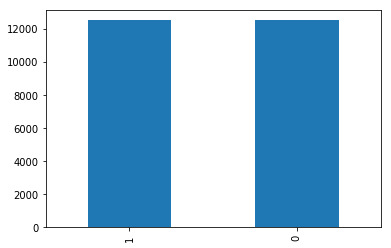

In [0]:
df['category'].value_counts().plot.bar()

### See sample image

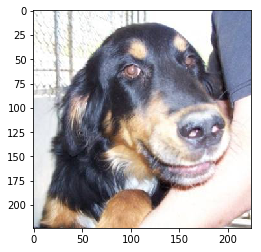

In [0]:
sample = random.choice(filenames)
image = load_img(TRAIN_PATH + sample, target_size=IMAGE_SIZE)
plt.imshow(image)

## Build Model
Use vgg16 trained model

In [0]:
pre_trained_model = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
pre_trained_model.summary()

W0906 05:31:28.171272 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 05:31:28.218244 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 05:31:28.226061 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 05:31:28.269570 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 3s 0us/step


W0906 05:31:31.876612 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 05:31:31.877904 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Prediction MLP layers

In [0]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
x = BatchNormalization()(pre_trained_model.output)
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
predictions = Dense(units=2, activation="softmax")(x) # 2 because we have cat and dog classes

model = Model(inputs=pre_trained_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

W0906 05:31:35.647637 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0906 05:31:36.008131 139687274784640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 05:31:36.037710 139687274784640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Split to training and validation data


In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
train_df.head()

,filename,category
0,dog.6667.jpg,dog
1,dog.1365.jpg,dog
2,dog.578.jpg,dog
3,cat.11527.jpg,cat
4,dog.9530.jpg,dog


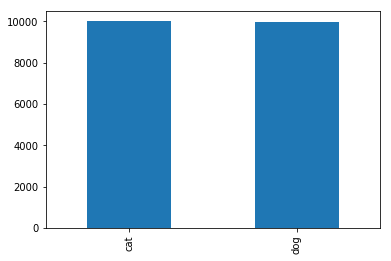

In [0]:
train_df['category'].value_counts().plot.bar()

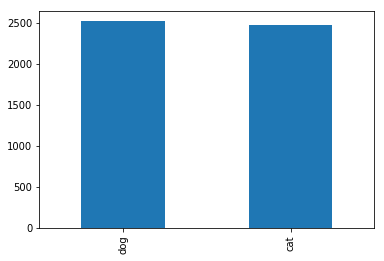

In [0]:
validate_df['category'].value_counts().plot.bar()


In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
print(total_train, total_validate)

20000 5000


## Image Preprocessing
Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
https://keras.io/preprocessing/image/
https://chtseng.wordpress.com/2017/11/11/data-augmentation-%E8%B3%87%E6%96%99%E5%A2%9E%E5%BC%B7/

### Traning Generator


In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=TRAIN_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator


In [0]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    directory=TRAIN_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### See how our generator work

In [0]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,cat.8143.jpg,cat


In [0]:
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory=TRAIN_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


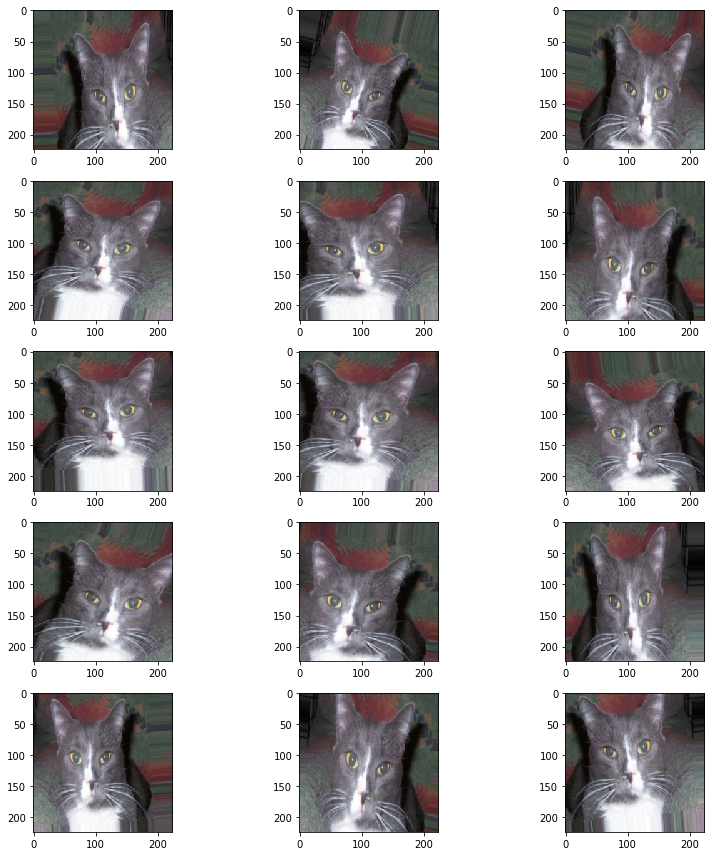

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model


### Callbacks
1. Early Stop: To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
2. Learning Rate Reduction: We will reduce the learning rate when then accuracy not increase for 2 steps

In [0]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [0]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
)

Epoch 1/10
400/400 [==============================] - 403s 1s/step - loss: 0.3917 - acc: 0.8758 - val_loss: 0.2296 - val_acc: 0.8998
Epoch 2/10
400/400 [==============================] - 388s 969ms/step - loss: 0.2039 - acc: 0.9151 - val_loss: 0.1606 - val_acc: 0.9316
Epoch 3/10
400/400 [==============================] - 390s 975ms/step - loss: 0.1820 - acc: 0.9229 - val_loss: 0.1484 - val_acc: 0.9412
Epoch 4/10
400/400 [==============================] - 393s 981ms/step - loss: 0.1682 - acc: 0.9301 - val_loss: 0.1530 - val_acc: 0.9400
Epoch 5/10
400/400 [==============================] - 394s 986ms/step - loss: 0.1537 - acc: 0.9365 - val_loss: 0.1486 - val_acc: 0.9404

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
400/400 [==============================] - 395s 988ms/step - loss: 0.1286 - acc: 0.9485 - val_loss: 0.1450 - val_acc: 0.9422
Epoch 7/10
400/400 [==============================] - 394s 985ms/step - loss: 0.1149 - acc: 0.9553 - val_l

### Save model

In [0]:
!mkdir -p '/content/drive/My Drive/colab/dogs-vs-cats/output'
model.save(OUTPUT_PATH + 'model.h5')

### Virtualize Training

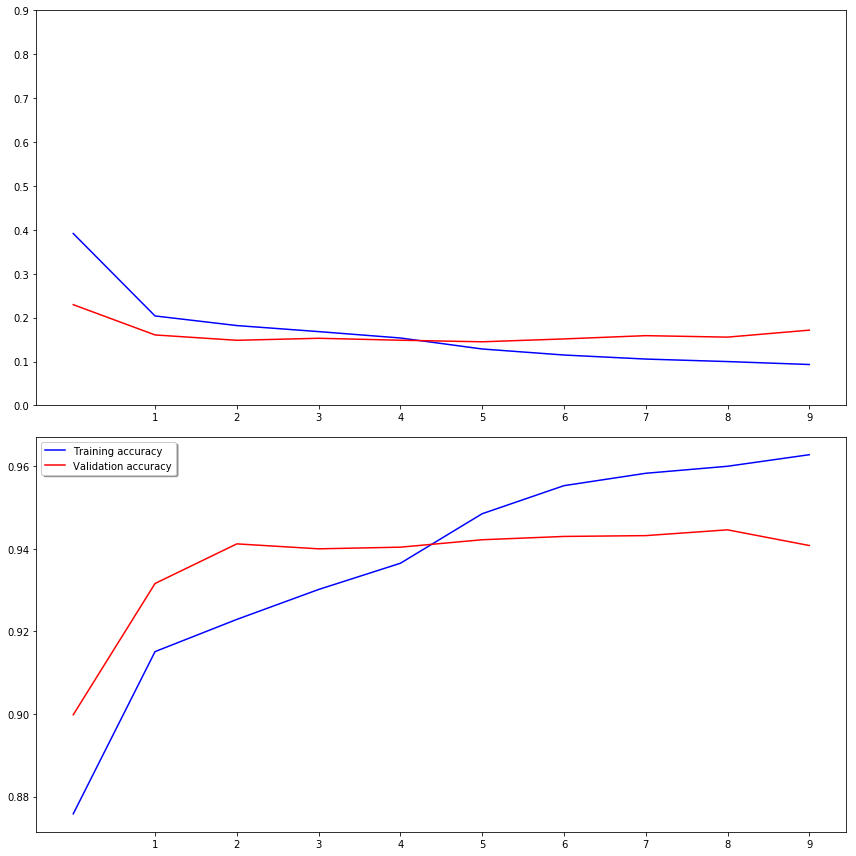

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data


In [0]:
test_filenames = os.listdir(TEST_PATH)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

12500

### Create Testing Generator


In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict

array([[1.9869879e-01, 8.0130124e-01],
       [6.7045785e-02, 9.3295419e-01],
       [1.2693627e-05, 9.9998736e-01],
       ...,
       [3.3751866e-01, 6.6248137e-01],
       [9.9028063e-01, 9.7193988e-03],
       [4.2470326e-03, 9.9575293e-01]], dtype=float32)

In [0]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df.head()

,filename,category
0,3853.jpg,1
1,896.jpg,1
2,984.jpg,1
3,549.jpg,0
4,2371.jpg,0


In [0]:
print(train_generator.class_indices.items())
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

dict_items([('cat', 0), ('dog', 1)])


{0: 'cat', 1: 'dog'}

In [0]:
test_df['category'] = test_df['category'].replace(label_map)
test_df.head()

,filename,category
0,3853.jpg,dog
1,896.jpg,dog
2,984.jpg,dog
3,549.jpg,cat
4,2371.jpg,cat


### Virtaulize Result

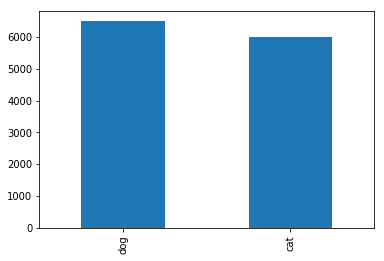

In [0]:
test_df['category'].value_counts().plot.bar()


### See predicted result with images

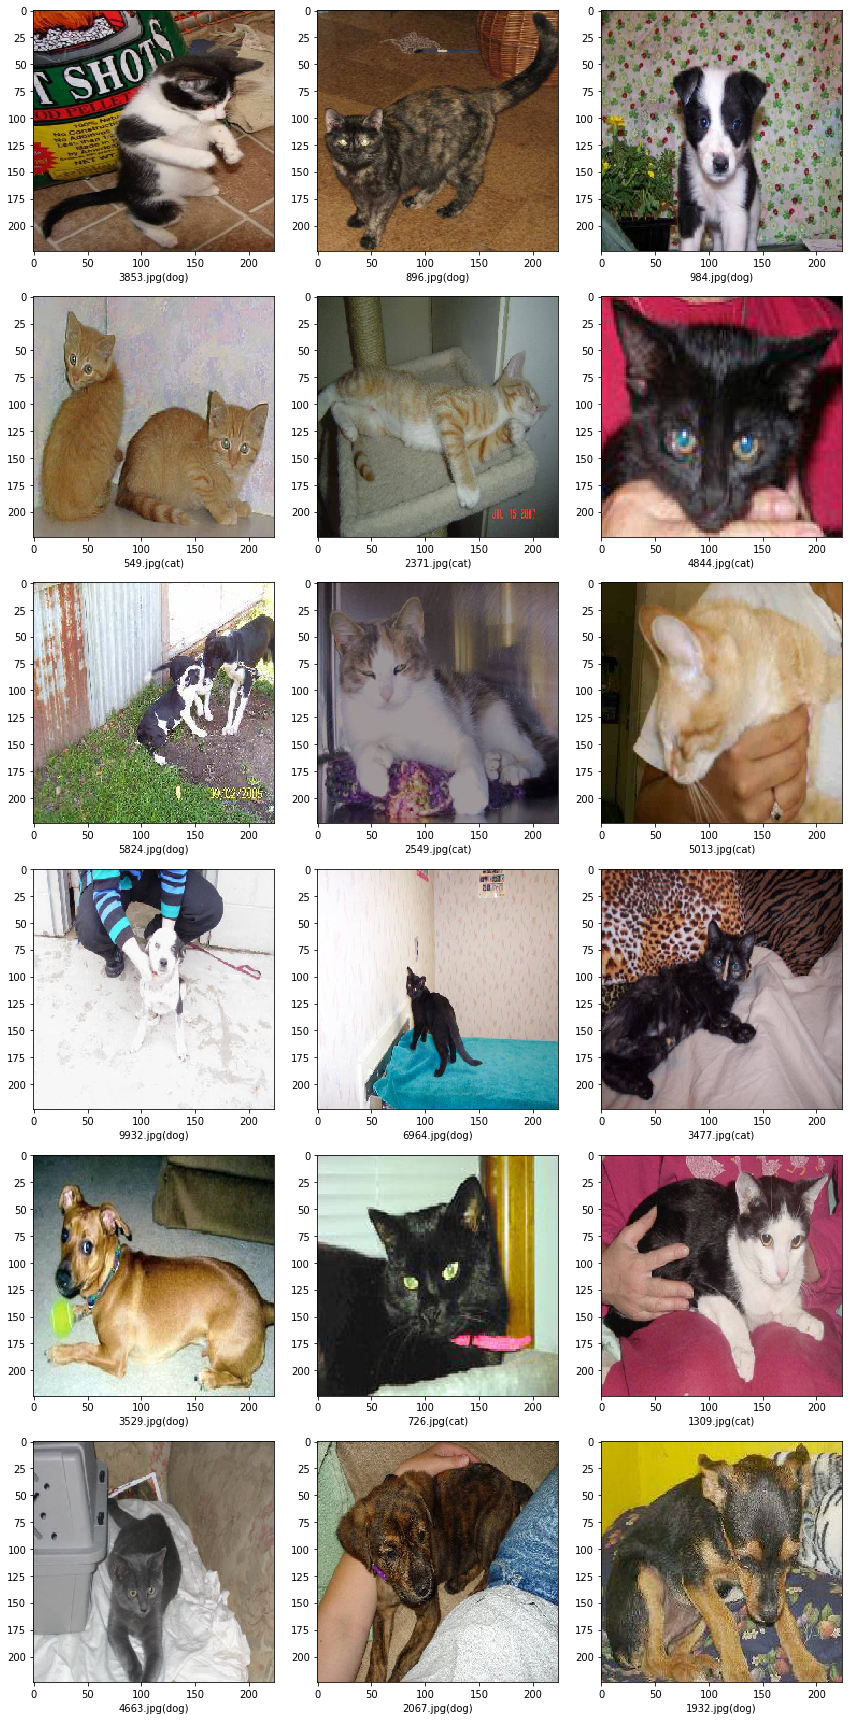

In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_PATH+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [0]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)

In [0]:
sample1 = test_df.sample(1)
sample1['filename'] = TEST_PATH + sample1['filename']
print(sample1)
sample_filename = sample1['filename'].item()
print(sample_filename)

                               filename  category
10265  /content/dataset//test1/4735.jpg         0
/content/dataset//test1/4735.jpg


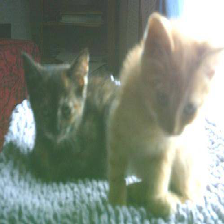

In [0]:
from keras.preprocessing.image import load_img
sample_img = load_img(sample_filename, target_size=IMAGE_SIZE)
sample_img

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
x1 = image.img_to_array(sample_img)
print(x1)
x1 = np.expand_dims(x1, axis=0)
print(x1)
x1 = preprocess_input(x1)
print(x1)

[[[ 69.  80.  84.]
  [ 71.  82.  84.]
  [ 69.  81.  81.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[ 70.  82.  82.]
  [ 71.  83.  83.]
  [ 69.  81.  79.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[ 70.  82.  80.]
  [ 70.  82.  80.]
  [ 70.  82.  78.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[100. 133. 116.]
  [103. 139. 125.]
  [104. 144. 135.]
  ...
  [186. 217. 222.]
  [136. 169. 174.]
  [116. 145. 153.]]

 [[ 94. 127. 110.]
  [ 95. 131. 117.]
  [ 94. 134. 125.]
  ...
  [195. 225. 233.]
  [147. 180. 185.]
  [117. 150. 159.]]

 [[ 78. 111.  94.]
  [ 74. 110.  96.]
  [ 70. 110. 101.]
  ...
  [213. 241. 252.]
  [189. 219. 229.]
  [158. 192. 204.]]]
[[[[ 69.  80.  84.]
   [ 71.  82.  84.]
   [ 69.  81.  81.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[ 70.  82.  82.]
   [ 71.  83.  83.]
   [ 69.  81.  79.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[

In [0]:
sample_pre = model.predict(x1)
print(sample_pre)
print(sample_pre.argmax(axis=-1))
label_map

[[9.9999571e-01 4.2666165e-06]]
[0]


{0: 'cat', 1: 'dog'}